# 2020-05-08
## Segmenting MS2 spots

I've now got nuclear masks that I think are ok, time to do some dot-finding. There seem to be a million different ways to do this. I'm reading some papers and such. I think what I'm going to start by is just feeling out the MS2 channel data. Try some filtering, thresholding, see what it does.

In [1]:
# Import public packages.
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import ndimage as ndi 
# from skimage import filters, measure, segmentation, transform, exposure, img_as_ubyte, feature, morphology
#from skimage import filters, io
from functools import partial
from importlib import reload
from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

In [2]:
# Import my packages.
import sys
sys.path.append('/Users/MStadler/Bioinformatics/Projects/Zelda/Quarantine_analysis/bin')
from imagep import (read_tiff_folder, read_tiff_lattice, viewer, viewer, 
                    segment_embryo, labelmask_apply_morphology, zstack_normalize_mean,
                   peak_local_max_nD, gradient_nD, labelmask_filter_objsize, filter_labelmask,
                   object_circularity)
import imagep as imp
reload(imp);

In [3]:
# Load stack.
stack = read_tiff_lattice(
    '/Users/MStadler/Bioinformatics/Projects/Zelda/Quarantine_analysis/data/20171207_Zldeve_em5_mv2/',
    span=(0,3))

/Users/MStadler/opt/anaconda3/lib/python3.7/site-packages/skimage/external/tifffile/tifffile.py:2135: UserWarning: tags are not ordered by code
  warnings.warn("tags are not ordered by code")


In [4]:
red = stack[0,0,56]

In [5]:
smooth = ndi.filters.gaussian_filter(red, sigma=2)

In [6]:
#viewer(red, 'xy')
#fig, ax = plt.subplots(8, 1, figsize=(100,5));
sigmas = np.copy(red);
sigmas = np.expand_dims(sigmas, 0);
for n in range(1,8):
    smooth = ndi.filters.gaussian_filter(red, sigma=n);
    smooth = np.expand_dims(smooth, 0);
    sigmas = np.concatenate((sigmas, smooth), axis=0)
    #_ = ax[n].imshow(smooth);

In [7]:
viewer(sigmas,'sxy')

interactive(children=(Dropdown(description='Color', index=3, options=('Greens', 'cividis', 'gray_r', 'viridis'…

This is interesting. Even very small values for sigma the spots seem a little weakened. Then again, background seems to go down. Let's try a media filter?

This is interesting. Even very small values for sigma the spots seem a little weakened. Then again, background seems to go down. Let's try a media filter

In [8]:
sigmas = np.copy(red);
sigmas = np.expand_dims(sigmas, 0);
for n in range(1,8):
    smooth = ndi.filters.median_filter(red, n);
    smooth = np.expand_dims(smooth, 0);
    sigmas = np.concatenate((sigmas, smooth), axis=0)
    #_ = ax[n].imshow(smooth);


In [9]:
viewer(sigmas, 'sxy')

interactive(children=(Dropdown(description='Color', index=3, options=('Greens', 'cividis', 'gray_r', 'viridis'…

My impression is the median filter preserves the spots better with a similar reduction in background. Maybe let's just have fun with filters. Try out some other filters.

In [10]:
############################################################################
def dog_filter(stack, sigma_big, sigma_small):
    """Difference of Gaussians filter
    
    Args:
        stack: ndarray
            n-dimensional image stack
        sigma_big: int
            Larger sigma for gaussian filter
        sigma_small: int
            Smaller sigma for gaussian filter
    
    Returns:
        dog: ndarray
            DoG filtered stack of same shape as input stack.
    """
    stack_cp = stack.astype(np.int16)
    return ndi.filters.gaussian_filter(stack_cp, sigma=sigma_big) - ndi.filters.gaussian_filter(stack_cp, sigma=sigma_small)

############################################################################
def log_filter(stack, sigma):
    """Laplacian of Gaussian filter
    
    Args:
        stack: ndarray
            n-dimensional image stack
        sigma: int
            Sigma for gaussian filter
    
    Returns:
        log: ndarray
            LoG filtered stack of same shape as input stack.
    """
    stack_cp = stack.astype(np.int16)
    gauss = ndi.filters.gaussian_filter(stack_cp, sigma=sigma)
    log = ndi.filters.laplace(gauss)
    return log

############################################################################
def qax(n, ncol=4):
    """Quick axes: generate 1d list of axes objects of specified number
    
    Args:
        n: int
            Number of plots desired
            
    Returns:
        ax1d: list
            1D list of axes objects in order top left to bottom right (columns
            then rows)
    """
    nrow = int(np.ceil(n / ncol))
    fig, ax = plt.subplots(nrow, ncol, figsize=(16, 4*nrow))
    ax1d = []
    pos1d = 0
    if (nrow > 1):
        for r in range(0, nrow):
            for c in range(0, ncol):
                ax1d.append(ax[r][c])
                pos1d = pos1d + 1
    else:
        for c in range(0, ncol):
            ax1d.append(ax[c])
            pos1d = pos1d + 1
    
    return ax1d

############################################################################
def plot_ps(func, span=range(0,8)):
    """Plot a parameter series in a specified range
    
    User supplies a plotting function that takes a single integer input as
    a parameter. plot_ps builds axes to display all parameter values and
    serially calls plot function on them.
    
    Example:
       def temp(x):
            dog = dog_filter(red, x, 3)
            plt.imshow(dog)

        plot_ps(temp, range(8,13)) 
    
    Args:
        func: function
            Must take a single integer value as a parameter and call a plot
            function on the active axes object.
        span: range
            Range object containing values of parameter to plot. 
    """
    nplots = len(span)
    ax = qax(int(len(span)));
    for pln in range(0, len(span)):
        plt.sca(ax[pln])
        func(span[pln])
    
    

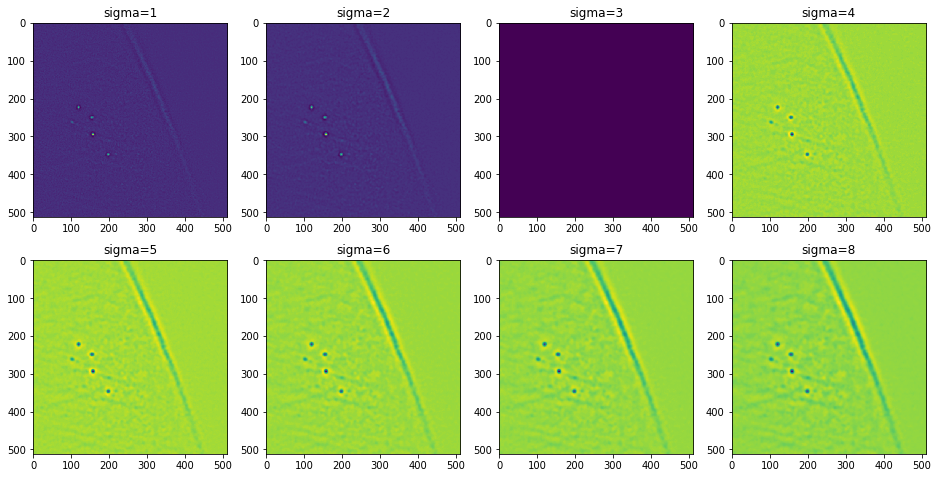

In [11]:
def test(x):
    a = dog_filter(red, x, 3)
    plt.title('sigma='+str(x))
    plt.imshow(a);

#ax=qax(8)
plot_ps(test, range(1,9));

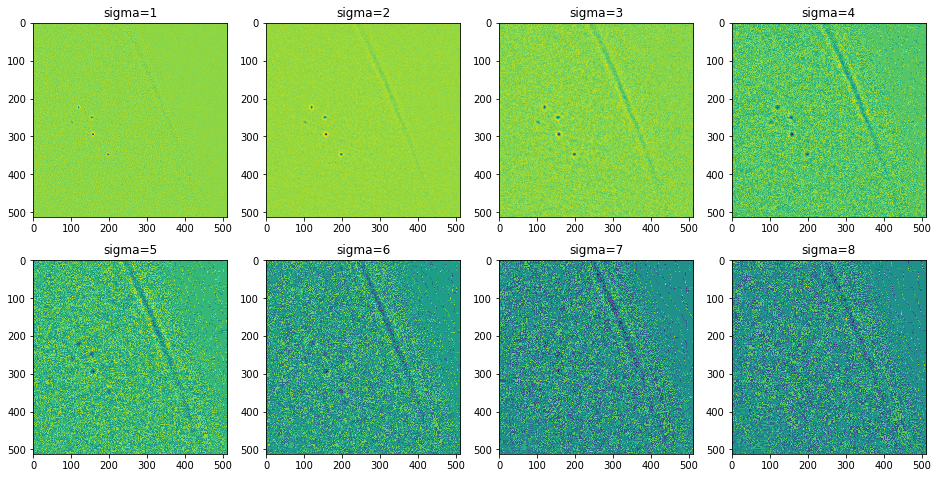

In [12]:
def test(x):
    a = log_filter(red, x);
    plt.title('sigma='+str(x))
    plt.imshow(a);

plot_ps(test, range(1,9));

Well it's interesting to see what these filters do, but nothing really to see here. Let's look at the median and gaussian filters:

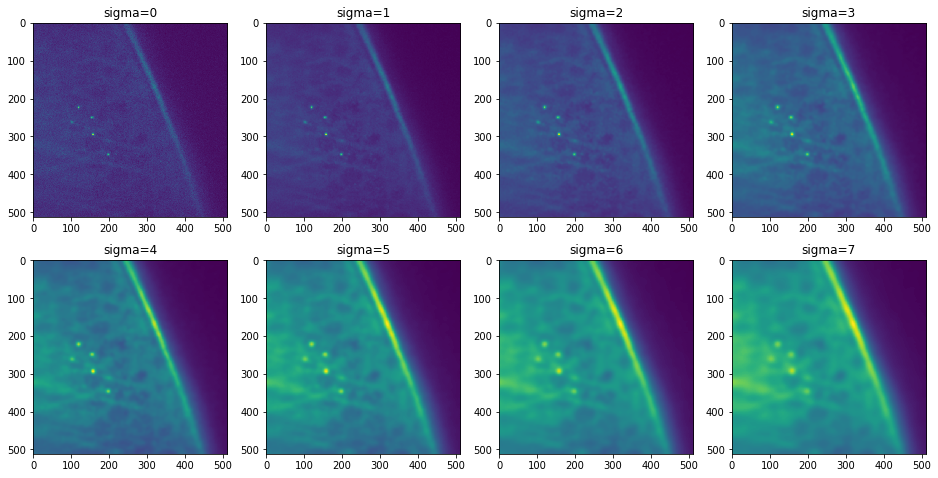

In [13]:
# Gaussian
def test(x):
    a = ndi.filters.gaussian_filter(red, sigma=x);
    plt.title('sigma='+str(x))
    plt.imshow(a);

plot_ps(test, range(0,8));

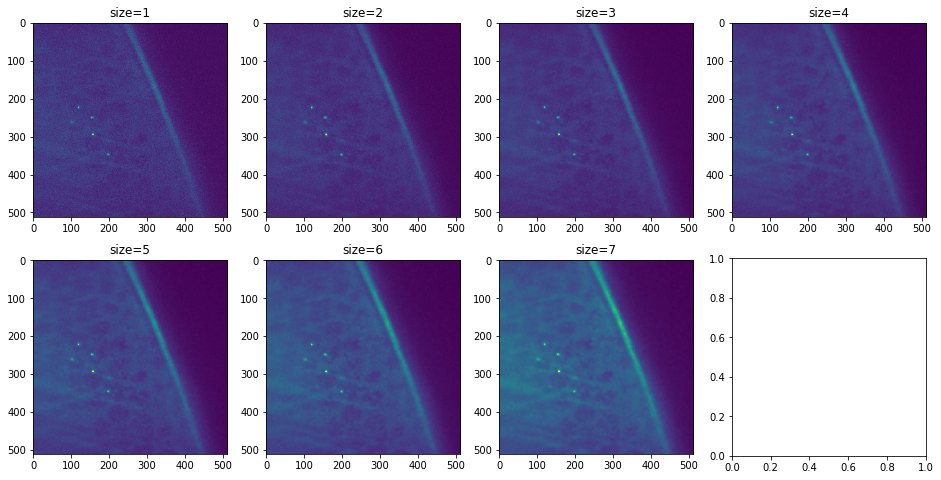

In [14]:
# Gaussian
def test(x):
    a = ndi.filters.median_filter(red, x)
    plt.title('size='+str(x))
    plt.imshow(a);

plot_ps(test, range(1,8));

In [15]:
'''
from skimage.filters.thresholding import threshold_li, threshold_otsu
# Gaussian
def test(x):
    a = ndi.filters.median_filter(red, x)
    t = threshold_otsu(a)
    a = np.where(a > t[-1], a, 0)
    plt.title('size='+str(x))
    plt.imshow(a);

plot_ps(test, range(1,8));
'''

"\nfrom skimage.filters.thresholding import threshold_li, threshold_otsu\n# Gaussian\ndef test(x):\n    a = ndi.filters.median_filter(red, x)\n    t = threshold_otsu(a)\n    a = np.where(a > t[-1], a, 0)\n    plt.title('size='+str(x))\n    plt.imshow(a);\n\nplot_ps(test, range(1,8));\n"

In [16]:
from skimage.filters.thresholding import threshold_li, threshold_otsu, threshold_multiotsu

OK, this has been fun I guess. I don't think it got me anywhere. There's potentially a million places to start, I decided to take a look at the smFISH paper from Ruth Lehmann [Trcek et al 2017 Nature Protocols](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6668020/pdf/nihms-937405.pdf). They use a custom spot detection algorithm called Airlocalize whose steps they describe thusly:

1. spatial bandpass filter is
implemented to identify candidate spots for further analysis
2. local background
surrounding the fluorescent spots is subtracted from the integral fluorescent intensity of a
spot to remove any residual offset or unevenness in the image
3. 2-dimensional (for 2D
images) or 3-dimensional (for 3D images) Gaussian mask fitting of each fluorescent spot is
implemented to find the center and the intensity of each spot
4. culling of spots based
on duplication and/or an intensity threshold. Spot intensities and positions are written to a
data file for further analysis (Fig. 3,4).
Parameters affecting single molec

I'll try using this as kind of a template and see where that gets me. The spatial bandpass filter seems like a DoG. Let's play with this some more I guess?

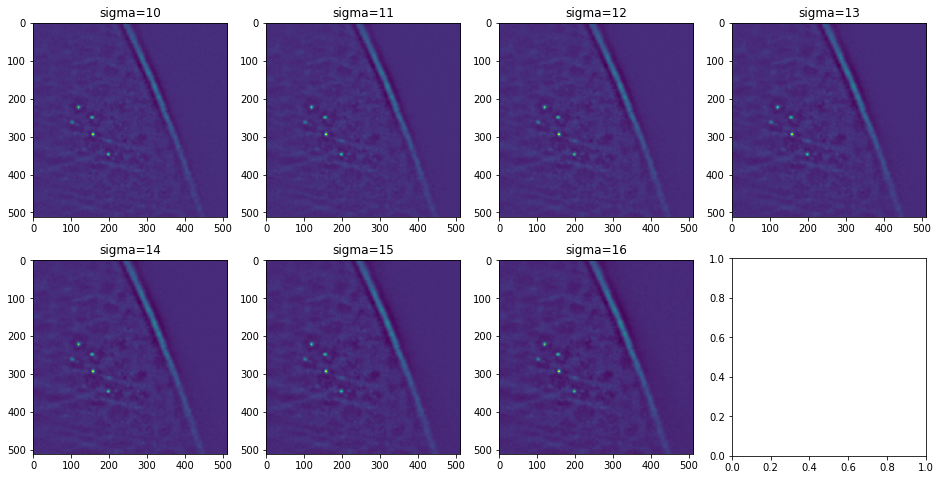

In [17]:
def test(x):
    a = dog_filter(red, 2, x)
    plt.title('sigma='+str(x))
    plt.imshow(a);

#ax=qax(8)
plot_ps(test, range(10,17));

In [18]:
#a = dog_filter(red,5,2)
b1 = ndi.filters.gaussian_filter(red,2)
b2  = ndi.filters.gaussian_filter(red,5)
c = np.subtract(b2, b1)

In [19]:
pt = (0,28)
print(b1[pt])
print(b2[pt])
print(c[pt])

185
183
65534


Interesting problem here. Subtracting uints is problematic. instead of negative numbers we go around the horn and 185-183 = 65534. This is an issue for doing dog and log filters correctly. I updated my dog_filter function to first cast the array as np.int16 which allows negative numbers. This works:

In [20]:
#a = dog_filter(red,5,2)
b1 = ndi.filters.gaussian_filter(red,2)
b2  = ndi.filters.gaussian_filter(red,5)
c = dog_filter(red, 5, 2)
pt = (0,28)
print(b1[pt])
print(b2[pt])
print(c[pt])

185
183
-2


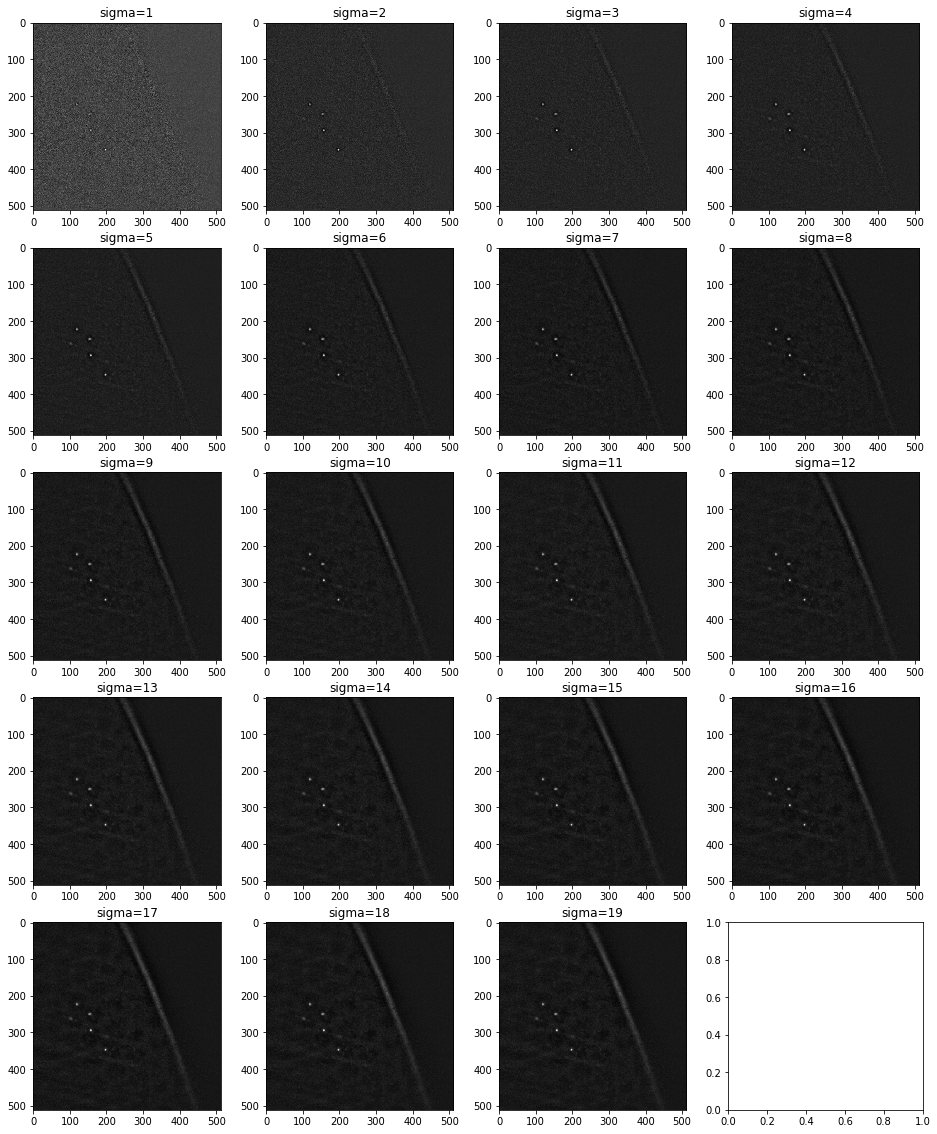

In [21]:
def test(x):
    a = dog_filter(red, 0.5, x)
    plt.title('sigma='+str(x))
    plt.imshow(a, cmap='gray');

#ax=qax(8)
plot_ps(test, range(1,20));

I played around with this and the world makes sense finally. This looks properly like a bandpass filter. It seems like values in the range of [0.5-1, 4] work pretty well to get rid of background and highlight spots. Cool.

OK so let's start with a bandpass filter of dog [0.5, 4]. That's step 1.

How about local background subtraction (step 2?)

In [22]:
s1 = dog_filter(red, 0.5, 4)

How about a median filter?

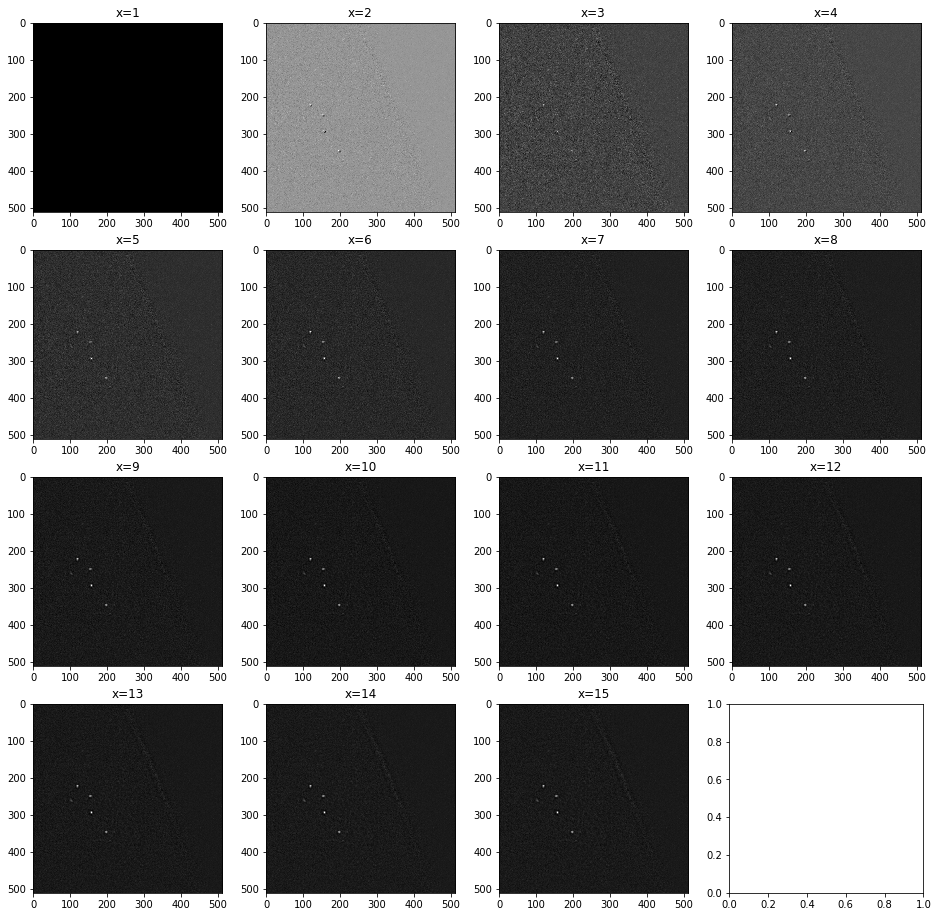

In [23]:
def test(x):
    a = ndi.filters.median_filter(s1, x)
    b = s1 - a.astype(np.int16)
    plt.title('x='+str(x))
    plt.imshow(b, cmap='gray');

#ax=qax(8)
plot_ps(test, range(1,16));

Pretty good honestly. I'll try a few more:

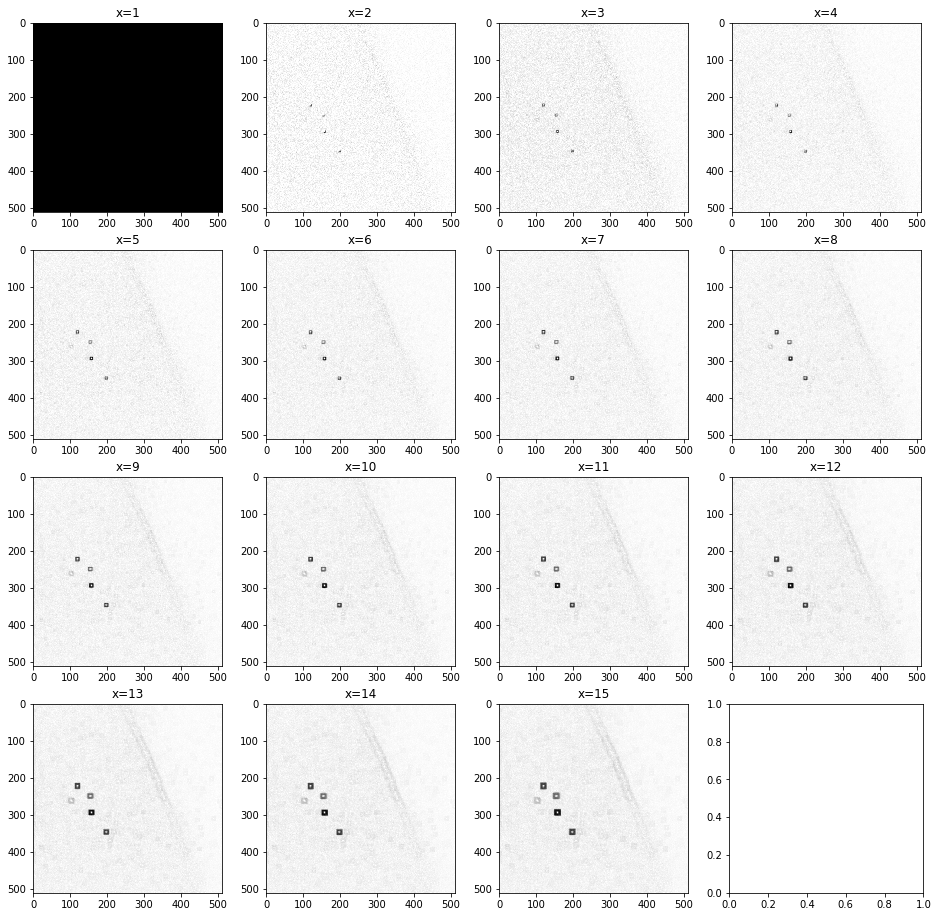

In [24]:
def test(x):
    a = ndi.filters.maximum_filter(s1, x)
    b = s1 - a.astype(np.int16)
    plt.title('x='+str(x))
    plt.imshow(b, cmap='gray');

#ax=qax(8)
plot_ps(test, range(1,16));

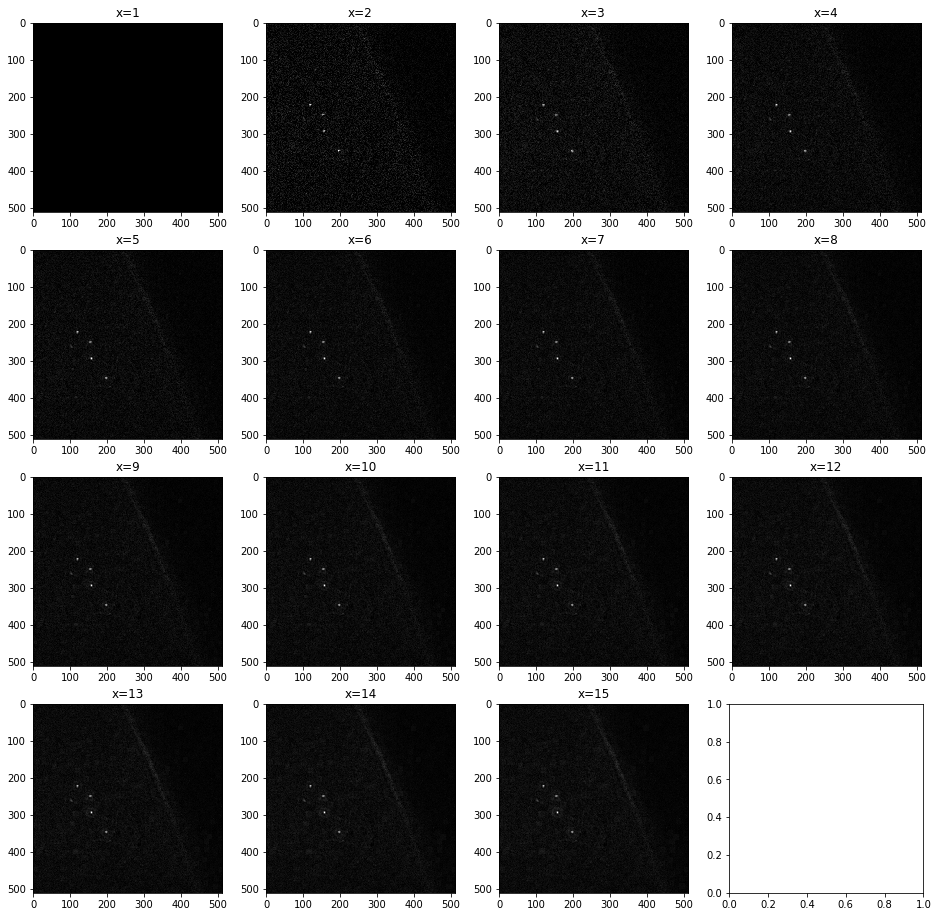

In [25]:
def test(x):
    a = ndi.filters.minimum_filter(s1, x)
    b = s1 - a.astype(np.int16)
    plt.title('x='+str(x))
    plt.imshow(b, cmap='gray');

#ax=qax(8)
plot_ps(test, range(1,16));

These all look promising at knocking down background (specifically embryo border--shouldn't be necessary with good nuclear segmentation). Median filter looks fine for now. Let's provisionally go with dog[0.5, 4] -> median[8].

Can't help but note the maximum filter though. Draws a pretty sweet box around the spots. Could be useful in the future...

Step 3 is to fit a gaussian mask. No clue how to do that. I broke out of this notebook and learned a little about this in 'curve fitting lesson' notebook. Basically it seems that I'll need to use scikit's curve_fit function, defining my own function for a 3D Gaussian. Not too tough.

Toward data science super helpful. [This](https://towardsdatascience.com/basic-curve-fitting-of-scientific-data-with-python-9592244a2509) is the tutorial I used for curve fitting, and [this](https://towardsdatascience.com/a-python-tutorial-on-generating-and-plotting-a-3d-guassian-distribution-8c6ec6c41d03) is what I used for 3D Gaussians.

***********************************

OK, I did a bunch with fitting and ended up writing functions to fit a 3D gaussian in the other notebook. I made a new python file/module __fitting.py__ from which I should be able to just import the function __fitgaussian__ and party on. Let's try:

In [147]:
sys.path.append('/Users/MStadler/Bioinformatics/Projects/Zelda/Quarantine_analysis/bin')
from fitting import fitgaussian, gaussian3d, fit_viewable, moments3d

In [27]:
test = stack[0,0]
test = ndi.filters.gaussian_filter(test, 1)
viewer(test,'zxy')

interactive(children=(Dropdown(description='Color', index=3, options=('Greens', 'cividis', 'gray_r', 'viridis'…

In [28]:
sm = test[48:64,245:255,150:160]
viewer(sm,'zxy')

interactive(children=(Dropdown(description='Color', index=3, options=('Greens', 'cividis', 'gray_r', 'viridis'…

In [29]:
def fit_viewable(data, p):
    print(p)
    f = gaussian3d(*p)
    x, y, z = np.indices(data.shape)
    fit = f(x, y, z)
    return fit

p = fitgaussian(sm)
fit = fit_viewable(sm, p)
viewer([sm,fit],'zxy')

[441.35150243   6.38673683   5.18049055   4.01242186   8.08562458
   5.03354269   6.34849664]


interactive(children=(Dropdown(description='Color', index=3, options=('Greens', 'cividis', 'gray_r', 'viridis'…

So the next step in the Lionnet analysis is Gaussian fit. What do I fit to? I think the simplest thing would be to do a find max peaks within nucleus-sized windows. I could fit them all or pre-screen them with some sort of intensity threshold. Let's play.

In [31]:
#def seg(x):
#a = dog_filter(x, 0.5, 4)
#bg = ndi.filters.median_filter(a, 8)
#b = a - bg
#mask, peaks = peak_local_max_nD(b, (70,50,50))
#mask = ndi.morphology.binary_dilation(mask,structure=np.ones((3,8,8)))
#viewer([b.max(axis=0),255*mask.max(axis=0)],'zxy')
    
#seg(stack[0,0])

In [35]:
x=stack[0,0]
#a = dog_filter(x, 0.5, 4)

bg = ndi.filters.median_filter(x, 8)
#b = a - bg

Hmm, the median filter is __EXTRAORDINARILY__ slow. The median on one 3D stack with size 8 takes minutes. Seems to increase very much with size. Comparably sized minimum filter is near-instant. This seems curious...I get that a median might be more computationally intense (gotta sort the values for each point in the image). Maybe the min/max filters are written intelligently (keep a running min max and update when you move over one without redoing the whole filter?), but it seems excessive for a simple median filter to take this long. Fiji, for example, doesn't seem to perform this way. Going to time this:

In [44]:
from time import process_time 
  
 
t1_start = process_time()  
   
for i in range(1,5): 
    t1_start = process_time()  
    bg = ndi.filters.median_filter(x, i)
    t1_stop = process_time() 
    print(str(t1_stop - t1_start))

0.017721999999992022
3.070683000000031
10.253055999999958
21.490477999999996


In [43]:
from time import process_time 
  
 
t1_start = process_time()  
   
for i in range(1,8): 
    t1_start = process_time()  
    bg = ndi.filters.minimum_filter(x, i)
    t1_stop = process_time() 
    print(str(t1_stop - t1_start))

0.018047000000024127
1.3895760000000337
1.464999999999975
1.4333649999999807
1.4696439999999598
1.4501030000000128
1.4927259999999478


I did a little googling, and it looks like the time complexity of median filters is a pretty well-established problem (increases with radius of kernel, a little unclear what the actual scaling is for 3D...). I think the problem may get worse with 3d, and the faster performance on imageJ probably reflects that it's just doing 2D filtering on the slices of the stack. So maybe I'll try using the minimum filter for background subtraction...

In [53]:
#def seg(x):
a = dog_filter(x, 0.5, 4)
bg = ndi.filters.minimum_filter(a, 4)
b = a - bg
mask, peaks = peak_local_max_nD(b, (70,50,50))
#mask = ndi.morphology.binary_dilation(mask,structure=np.ones((3,8,8)))

Spots are about 10x10 laterally and ~20 z slices deep (why so deep????).

Option 1 is to filter max pixels then fit gaussians to those that pass. I think fitting first, if it's not overly time-intensive, is smarter because it will effectively allow filtering on intensity and shape. So I'll try fitting first, but defining windows around these peaks.

In [105]:
def get_fitwindow(data, peak, xy_rad=5, z_rad=9):
    zmin = max(0,peak[0] - z_rad)
    zmax = min(data.shape[0] - 1, peak[0] + z_rad)
    xmin = max(0,peak[1] - xy_rad)
    xmax = min(data.shape[1] - 1, peak[1] + xy_rad)
    ymin = max(0,peak[2] - xy_rad)
    ymax = min(data.shape[2] - 1, peak[2] + xy_rad)
    return data[zmin:zmax, xmin:xmax, ymin:ymax]
t_start = process_time() 
fitparams = np.ndarray((0,7))
for peak in peaks:
    fitwindow = get_fitwindow(stack[0,0], peak)
    p = fitgaussian(fitwindow)
    fitparams = np.vstack((fitparams,p))
t_end = process_time()
print(t_end - t_start)
    #viewer(c,'zxy')

20.58663100000001


That takes 20 seconds for a single 3D stack. Not necessarily prohibitive. Let's see how these things look:

Text(0.5, 1.0, 'Histogram of fit heights')

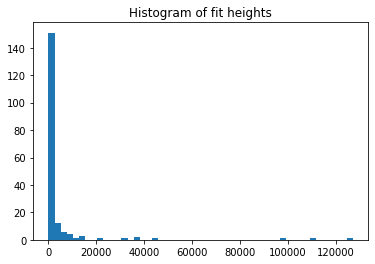

In [115]:
plt.hist(fitparams[:,0],bins=50);
plt.title('Histogram of fit heights')

Text(0.5, 1.0, 'Fit heights vs. x_width')

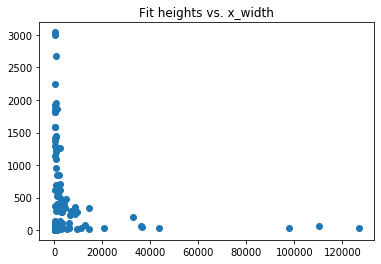

In [116]:
plt.scatter(fitparams[:,0], fitparams[:,5])
plt.title('Fit heights vs. x_width')

Text(0.5, 1.0, 'Fit heights vs. y_width')

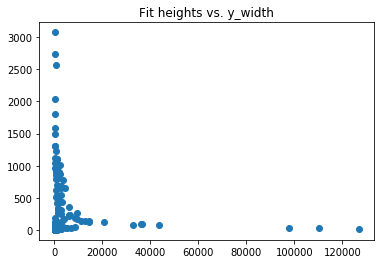

In [117]:
plt.scatter(fitparams[:,0], fitparams[:,6])
plt.title('Fit heights vs. y_width')

Looks like peak height alone is probably sufficient to distinguish, but fit width could be a useful additional parameter in some contexts (perhaps noisier or grainier data?). Looks like there should be around 15 spots.

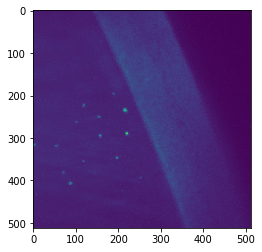

In [118]:
plt.imshow(stack[0,0].max(axis=0))

Let's try some filtering based on properties.

In [137]:
# The way peak_local_max_nD is written, peaks are in the order of np.unique on mask skipping first 0 
peak_ids = np.unique(mask)[1:]
trupeaks = peak_ids[fitparams[:,0] > 1000]
fmask = np.where(np.isin(mask, trupeaks),1,0)
fmask = ndi.morphology.binary_dilation(fmask, structure=np.ones((3,15,15)))

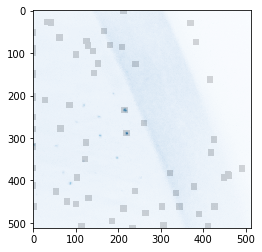

In [139]:
plt.imshow(fmask.max(axis=0),cmap="gray_r",alpha=0.5)
plt.imshow(stack[0,0].max(axis=0),cmap="Blues",alpha=0.7)

Hmmm this is strange. Need some help understanding why on earth it would have large fit heights on these nonsense peaks.

Text(0.5, 1.0, 'Fit Y-coord')

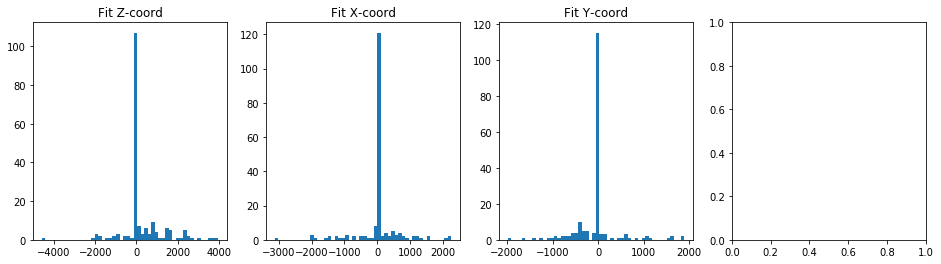

In [143]:
ax=qax(4)
ax[0].hist(fitparams[:,1], bins=50);
ax[0].set_title('Fit Z-coord')
ax[1].hist(fitparams[:,2], bins=50);
ax[1].set_title('Fit X-coord')
ax[2].hist(fitparams[:,3], bins=50);
ax[2].set_title('Fit Y-coord')

Fascinating! One would expect these values to be...within the image at a mimimum! I think what's happening is that many of the squares have no peak at all, they're essentially flat, so the fit is deciding that they are best fit by a huge signal that is located far away, so that the fit window is a flat little part of the far tail. Interesting! Good news is we can constrain the parameters in the fitting. For now I'll just constrain the centers to be within the fitting window, allowing the height and widths to be anything.

I also discovered that optimize.leastsq is a deprecated function, replaced by least_squares. This is convenenient since least_squares takes bounds and leastsq does not. least_squares is a non-linear least-squares function, returns an OptimizeResult object.

In [209]:
def fitgaussian3d(data):
    """Fit a gaussian
    
    Returns (height, z, x, y, width_z, width_x, width_y)
    the gaussian parameters of a 3D distribution found by a least squares 
    fit. Wrote for 3D, but will work for 2D.
    
    Args:
        data: ndarray
            The 3D data to fit in shape [z,x,y]
    Returns:
        opt: OptimizeResult
            opt.x: parameters of the fit: (height, z, x, y, width_z, width_x, width_y)
            opt.success: boolean: whether fit exited successfully
    """
    
    params = moments3d(data)
    # Error function is simple difference between gaussian function and data.
    errorfunction = lambda p: np.ravel(gaussian3d(*p)(*np.indices(data.shape)) -
                                 data)
    opt = optimize.least_squares(errorfunction, params, bounds=([-np.inf,0,0,0,-np.inf,-np.inf,-np.inf],[np.inf,data.shape[0]-1,data.shape[1]-1,data.shape[2]-1,np.inf,np.inf,np.inf]))
    return opt

In [153]:
from scipy import optimize
def get_fitwindow(data, peak, xy_rad=5, z_rad=9):
    zmin = max(0,peak[0] - z_rad)
    zmax = min(data.shape[0] - 1, peak[0] + z_rad)
    xmin = max(0,peak[1] - xy_rad)
    xmax = min(data.shape[1] - 1, peak[1] + xy_rad)
    ymin = max(0,peak[2] - xy_rad)
    ymax = min(data.shape[2] - 1, peak[2] + xy_rad)
    return data[zmin:zmax, xmin:xmax, ymin:ymax]
t_start = process_time() 
fitparams = np.ndarray((0,7))
for peak in peaks:
    fitwindow = get_fitwindow(stack[0,0], peak)
    p = fitgaussian3d(fitwindow)
    fitparams = np.vstack((fitparams,p))
t_end = process_time()
print(t_end - t_start)

9.356213999999909


Text(0.5, 1.0, 'Y')

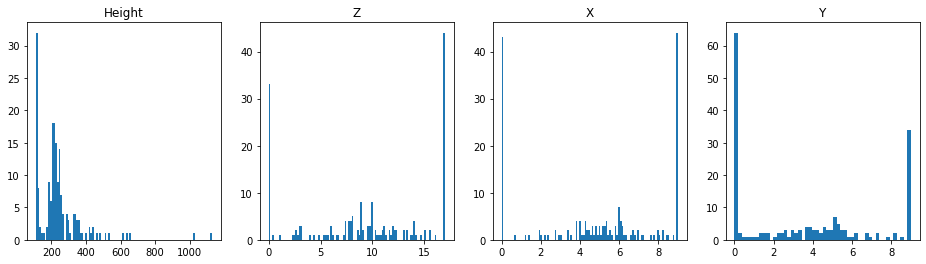

In [159]:
ax=qax(4)
ax[0].hist(fitparams[:,0], bins=100);
ax[0].set_title('Height')
ax[1].hist(fitparams[:,1], bins=100);
ax[1].set_title('Z')
ax[2].hist(fitparams[:,2], bins=100);
ax[2].set_title('X')
ax[3].hist(fitparams[:,3], bins=50);
ax[3].set_title('Y')

OK so this solved the problem, but it still interesting. The preference for having centers on the boundaries probably reflects the same phenomenon I observed before. Trixie fits! Anyway let's try our filtering again.

In [160]:
peak_ids = np.unique(mask)[1:]
trupeaks = peak_ids[fitparams[:,0] > 400]
fmask = np.where(np.isin(mask, trupeaks),1,0)
fmask = ndi.morphology.binary_dilation(fmask, structure=np.ones((3,15,15)))

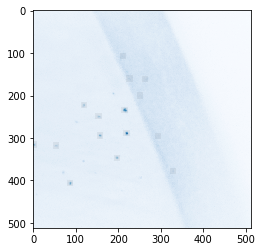

In [162]:
plt.imshow(fmask.max(axis=0),cmap="gray_r",alpha=0.5)
plt.imshow(stack[0,0].max(axis=0),cmap="Blues",alpha=0.9)

Seems like this performs better. Let's check the widths:

(0, 100)

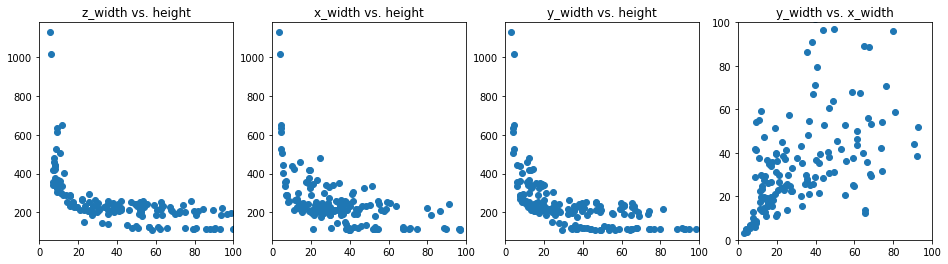

In [181]:
ax=qax(4)
ax[0].scatter(fitparams[:,4],fitparams[:,0])
ax[0].set_xlim((0,100))
ax[0].set_title('z_width vs. height')
ax[1].scatter(fitparams[:,5],fitparams[:,0])
ax[1].set_xlim((0,100))
ax[1].set_title('x_width vs. height')
ax[2].scatter(fitparams[:,6],fitparams[:,0])
ax[2].set_title('y_width vs. height')
ax[2].set_xlim((0,100))
ax[3].scatter(fitparams[:,6],fitparams[:,5])
ax[3].set_title('y_width vs. x_width')
ax[3].set_xlim((0,100))
ax[3].set_ylim((0,100))


This looks promising. Clear tail of presumably "real" points that have narrow extents (widths) and high peaks. 

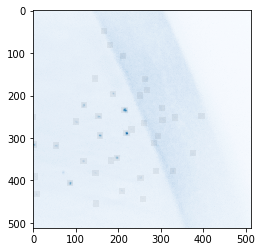

In [187]:
height_min=200
width_min=20
peak_ids = np.unique(mask)[1:]
trupeaks = peak_ids[(fitparams[:,0] > height_min) & (fitparams[:,5] < width_min) & (fitparams[:,6] < width_min)]
fmask = np.where(np.isin(mask, trupeaks),1,0)
fmask = ndi.morphology.binary_dilation(fmask, structure=np.ones((3,15,15)))
plt.imshow(fmask.max(axis=0),cmap="gray_r",alpha=0.5)
plt.imshow(stack[0,0].max(axis=0),cmap="Blues",alpha=0.9)

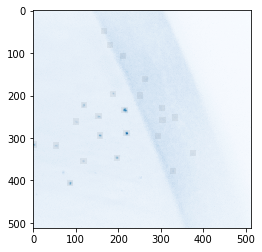

In [188]:
height_min=300
width_min=20
peak_ids = np.unique(mask)[1:]
trupeaks = peak_ids[(fitparams[:,0] > height_min) & (fitparams[:,5] < width_min) & (fitparams[:,6] < width_min)]
fmask = np.where(np.isin(mask, trupeaks),1,0)
fmask = ndi.morphology.binary_dilation(fmask, structure=np.ones((3,15,15)))
plt.imshow(fmask.max(axis=0),cmap="gray_r",alpha=0.5)
plt.imshow(stack[0,0].max(axis=0),cmap="Blues",alpha=0.9)

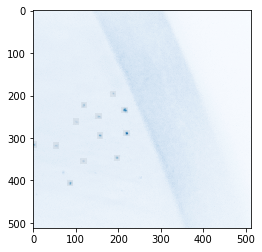

In [186]:
height_min=300
width_min=10
peak_ids = np.unique(mask)[1:]
trupeaks = peak_ids[(fitparams[:,0] > height_min) & (fitparams[:,5] < width_min) & (fitparams[:,6] < width_min)]
fmask = np.where(np.isin(mask, trupeaks),1,0)
fmask = ndi.morphology.binary_dilation(fmask, structure=np.ones((3,15,15)))
plt.imshow(fmask.max(axis=0),cmap="gray_r",alpha=0.5)
plt.imshow(stack[0,0].max(axis=0),cmap="Blues",alpha=0.9)

Looks like width ("peakiness") is more useful than height. Maybe not terribly surprising. How about width alone?

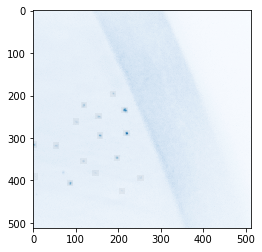

In [190]:
height_min=0
width_min=10
peak_ids = np.unique(mask)[1:]
trupeaks = peak_ids[(fitparams[:,0] > height_min) & (fitparams[:,5] < width_min) & (fitparams[:,6] < width_min)]
fmask = np.where(np.isin(mask, trupeaks),1,0)
fmask = ndi.morphology.binary_dilation(fmask, structure=np.ones((3,15,15)))
plt.imshow(fmask.max(axis=0),cmap="gray_r",alpha=0.4)
plt.imshow(stack[0,0].max(axis=0),cmap="Blues",alpha=0.9)

Interesting. Width alone does most of the work but we still need a bit of thresholding on height. What's a smart way to threshold? I'd like something simple and intuitive that just says "if it's substantially above the mean."

In [191]:
test = stack[0,0]
test.max()

1651

In [192]:
test.mean()

186.03671812302994

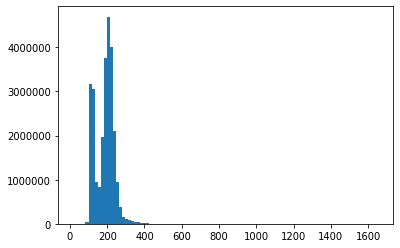

In [195]:
plt.hist(test.flatten(), bins=100);

In [199]:
np.percentile(test.flatten(),99)

318.0

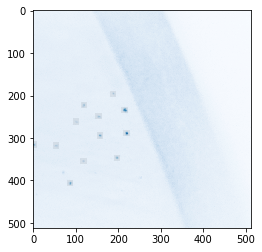

In [204]:
a = stack[0,0]
mean_ = np.mean(a)
p99 = np.percentile(a.flatten(),99)
multiplier = 0.8
t = mean_ + ((p99 - mean_) * multiplier)

height_min=t
width_min=10
peak_ids = np.unique(mask)[1:]
trupeaks = peak_ids[(fitparams[:,0] > height_min) & (fitparams[:,5] < width_min) & (fitparams[:,6] < width_min)]
fmask = np.where(np.isin(mask, trupeaks),1,0)
fmask = ndi.morphology.binary_dilation(fmask, structure=np.ones((3,15,15)))
plt.imshow(fmask.max(axis=0),cmap="gray_r",alpha=0.6)
plt.imshow(stack[0,0].max(axis=0),cmap="Blues",alpha=0.9)

This works pretty well. I'm gonna put it together into a function.

In [271]:
############################################################################
def segMS2_3dstack(stack, peak_window_size=(70,50,50), sigma_small=0.5, 
                   sigma_big=4, bg_radius=4, fitwindow_rad_xy=5, 
                   fitwindow_rad_z=9, h_thresh_multiplier=0.8, 
                   xy_max_width=10):  
    """Segment MS2 spots from a 3D stack, fit them with 3D gaussian
    
    Alrigthm: bandbass filter -> background subtraction -> find local maxima
    -> fit gaussian to windows around maxima -> filter based on fit parameters
    -> label and return.
    
    Args:
        stack: ndarray
            3D image stack containing MS2 spots
        peak_window_size: tuple of three ints
            Size in [z,x,y] of window used to find local maxima. Typically
            set to the approximage dimensions of nuclei.
        sigma_small: numeric
            Lower sigma for difference-of-gaussians bandpass filter
        sigma_small: numeric
            Upper sigma for difference-of-gaussians bandpass filter
        bg_radius: int
            Radius for minimum filter used for background subtraction
        fitwindow_rad_xy: int
            Radius in pixels in the xy-dimension of the window around local
            maxima peaks within which to do gaussian fitting.
        fitwindow_rad_z: int
            Radius in pixels in the z-dimension of the window around local
            maxima peaks within which to do gaussian fitting.
        h_thresh_multiplier: float
            Multiplier [0,1] used to set threshold for the minimum intensity 
            (height) for filtering gaussian fits. Threshold set according to:
            thresh = mean + (max - mean)*multplier
        xy_max_width: int
            Maximum width in xy-dimension used for filtering gaussian fits.
    
    Returns:
        labelmask: ndarray
            Segmented spots that pass filter. Labels are assigned to a single 
            pixel which is that returned by peak_local_max_nD. It is the 
            centroid of the object formed by all contiguous pixels constituting
            local maxima within a defined window. In 16-bit data, nearly always
            corresponds to the pixel of maximum intensity in the segmented object.
        fitparams: ndarray
            Parameters of gaussian fit for segmented spot. Each row is a spot 
            offset by 1 (object 1 is in row 0). Columns are:
            0: height (intensity), 1: z_center, 2: x_center, 3: y_center, 
            4: z_width, 5: x_width, 6: y_width.
    """
    def get_fitwindow(data, peak, xy_rad=5, z_rad=9):
        """Retrieve section of image stack corresponding to given
        window around a point"""
        zmin = max(0,peak[0] - z_rad)
        zmax = min(data.shape[0] - 1, peak[0] + z_rad)
        xmin = max(0,peak[1] - xy_rad)
        xmax = min(data.shape[1] - 1, peak[1] + xy_rad)
        ymin = max(0,peak[2] - xy_rad)
        ymax = min(data.shape[2] - 1, peak[2] + xy_rad)
        return data[zmin:zmax, xmin:xmax, ymin:ymax]
    
    def relabel(mask, p):
        """Renumber labelmask and corresponding fit parameters
        
        Set background as 0, objects in order 1...end
        """
        newmask = np.zeros_like(mask)
        params = np.ndarray((0, p.shape[1]))
        ids = np.unique(mask)
        for n in range(1,len(ids)):
            old_id = ids[n]
            new_id = n
            newmask[mask == old_id] = new_id
            params = np.vstack((params, p[old_id-1,:])) # object 1 will be fitparams row 0
        return newmask, params
    
    # Filter and background subtract image.
    dog = dog_filter(stack, sigma_small, sigma_big)
    bg = ndi.filters.minimum_filter(dog, bg_radius)
    dog_bs = dog - bg
    # Make a labelmask corresponding to local maxima peaks.
    mask, peaks = peak_local_max_nD(dog_bs, peak_window_size)
    
    # Fit 3D gaussian in window surrounding each local maximum.
    fitparams = np.ndarray((0,7))
    for peak in peaks:
        fitwindow = get_fitwindow(stack, peak, fitwindow_rad_xy, 
                                  fitwindow_rad_z)
        opt = fitgaussian3d(fitwindow)
        if opt.success:
            fitparams = np.vstack((fitparams, opt.x))
    
    # Find threshold for gaussian height (intensity for 3D).
    mean_ = np.mean(stack)
    p99 = np.percentile(stack.flatten(),99)
    t = mean_ + ((p99 - mean_) * h_thresh_multiplier)
    
    # Filter peaks based on guassian fit parameters.
    peak_ids = np.unique(mask)[1:]
    # fitparams columns: 0: height, 5: x_width, 6: y_width
    trupeaks = peak_ids[(fitparams[:,0] > t) 
                        & (fitparams[:,5] < xy_max_width) 
                        & (fitparams[:,6] < xy_max_width)]
    fmask = np.where(np.isin(mask, trupeaks),mask,0)
    labelmask, fitparams = relabel(fmask, fitparams)
    return labelmask, fitparams

OK, I think this is pretty good for now. MS2 spots decently segmented. Also, I can clean up any mess with the nuclear mask.

Next task (for new notebook): Connected spots.

In [279]:
area = 16
perimeter = 20
(4 * np.pi * area) / (perimeter**2)

0.5026548245743669